In [166]:
# HPC pass/fail classification model by Jiwon Park
# Supervised binary classification model version 1.0 (2022. 05. 16)
# Flow cytometry data should be prepared into subfraction concentration data
# Limitations: 1) Only fit for chlorinated drinking water system. 2) bias by stagnant tap samples
# Applications: Online FCM measurement to predict HPC regulatory pass/fail criteria

In [167]:
import pandas as pd
import seaborn as sb
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
table = pd.read_csv('data icc.csv', sep=',')  #Load your CSV data 

In [168]:
print(table.describe())
plt.figure(figsize=(5,3))
print(table["HPC_fail"].value_counts())
# HPC pass/fail label should be at the end of column 

          Free_Cl         ATP           ICC    HPC_fail
count  192.000000  192.000000    192.000000  192.000000
mean     0.113021   36.217708   8835.864583    0.187500
std      0.114271   38.393433  12940.708208    0.391333
min      0.000000    4.700000    148.000000    0.000000
25%      0.010000   12.700000    914.000000    0.000000
50%      0.080000   23.100000   1887.000000    0.000000
75%      0.220000   45.125000  14993.000000    0.000000
max      0.440000  226.100000  62718.000000    1.000000
0    156
1     36
Name: HPC_fail, dtype: int64


<Figure size 360x216 with 0 Axes>

In [169]:
#table_norm = (table - table.mean()) / (table.std())   # z score normalization: (data-mean)/(std)
table_norm = (table - table.min()) / (table.max()-table.min())   
#plt.hist(table_norm["HPC_fail"])

In [170]:
table_shuffle = table_norm.sample(frac=1)  # Sample order shuffle
#table_shuffle = table_norm.sample(frac=1, random_state = 119)  
print(table_shuffle.head()) # check your normalized data 
table_np = table_shuffle.to_numpy() 

      Free_Cl       ATP       ICC  HPC_fail
167  0.000000  0.044264  0.019722       0.0
21   0.022727  0.182475  0.658431       1.0
118  0.363636  0.087173  0.026658       0.0
17   0.000000  0.036134  0.039220       0.0
160  0.522727  0.117435  0.004283       0.0


In [171]:
train_idx = int(len(table_np)*0.8) 
train_X, train_Y = table_np[:train_idx, :-1], table_np[:train_idx, -1]
test_X, test_Y = table_np[train_idx:, :-1], table_np[train_idx:, -1]
train_Y = tf.keras.utils.to_categorical(train_Y, num_classes = 2) 
test_Y = tf.keras.utils.to_categorical(test_Y, num_classes = 2)

In [172]:
#activation function option 
# Too much modes or dense layers result in overfitting of model

model =tf.keras.Sequential([
    tf.keras.layers.Dense(units=16, activation='relu', input_shape=(3,)), # options: relu, tanh, or sigmoid
    tf.keras.layers.Dense(units=8, activation='softmax'),
    tf.keras.layers.Dense(units=2, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.07), # You can optimize learning rate
#loss='binary_crossentropy', metrics=['accuracy']) #option: categorical_ or binary_
loss='categorical_crossentropy', metrics=['accuracy']) 

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 16)                64        
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 18        
Total params: 218
Trainable params: 218
Non-trainable params: 0
_________________________________________________________________


In [173]:
#optimization is needed for numbers in epochs and batch size
#validation split affects the size of training/test data (we recommend 0.2 or 0.3)
history = model.fit(train_X, train_Y, epochs=150, batch_size=55, validation_split=0.2,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss")]) 
#Earlystopping will cease epoch automatically

Epoch 1/150
3/3 [==============================] - 1s 92ms/step - loss: 0.5591 - accuracy: 0.8197 - val_loss: 0.3773 - val_accuracy: 0.8710
Epoch 2/150
3/3 [==============================] - 0s 15ms/step - loss: 0.4216 - accuracy: 0.8197 - val_loss: 0.2890 - val_accuracy: 0.8710
Epoch 3/150
3/3 [==============================] - 0s 15ms/step - loss: 0.3532 - accuracy: 0.8197 - val_loss: 0.2354 - val_accuracy: 0.8710
Epoch 4/150
3/3 [==============================] - 0s 16ms/step - loss: 0.2981 - accuracy: 0.8197 - val_loss: 0.1933 - val_accuracy: 0.8710
Epoch 5/150
3/3 [==============================] - 0s 16ms/step - loss: 0.2372 - accuracy: 0.8197 - val_loss: 0.1622 - val_accuracy: 0.8710
Epoch 6/150
3/3 [==============================] - 0s 14ms/step - loss: 0.2162 - accuracy: 0.8607 - val_loss: 0.1610 - val_accuracy: 0.9032
Epoch 7/150
3/3 [==============================] - 0s 16ms/step - loss: 0.1903 - accuracy: 0.9098 - val_loss: 0.1730 - val_accuracy: 0.9032
Epoch 8/150
3/3 [===

<function matplotlib.pyplot.show(close=None, block=None)>

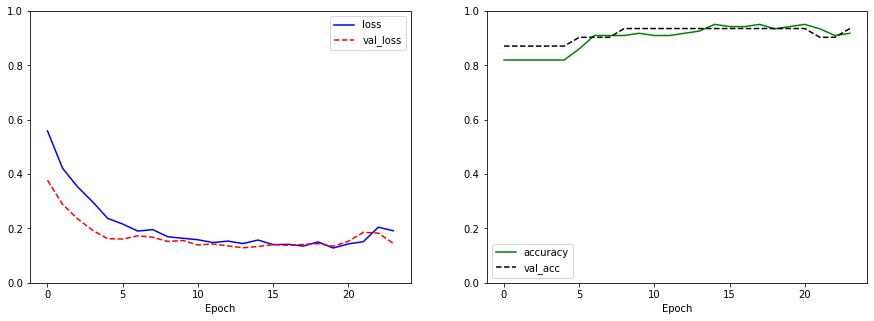

In [174]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.ylim(0.0, 1)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_acc')
plt.xlabel('Epoch')
plt.ylim(0.0, 1)
plt.legend()

plt.show

In [175]:
model.evaluate(test_X, test_Y)

2/2 [==============================] - 0s 2ms/step - loss: 0.1780 - accuracy: 0.9231


[0.1779530644416809, 0.9230769276618958]

In [176]:
pred_Y = model.predict(test_X)
y1=np.delete(pred_Y,0,1)
y2=np.transpose(y1)
print(y2)

[[0.00204256 0.00217653 0.00204976 0.8461073  0.00203055 0.84655625
  0.00601326 0.00203756 0.00345313 0.83771634 0.00203981 0.00209718
  0.00203044 0.8389212  0.8480231  0.0020859  0.00226244 0.84794664
  0.8476827  0.00306233 0.00208626 0.8478918  0.00300811 0.00205138
  0.00206065 0.00228201 0.00286286 0.00203272 0.00265895 0.0020349
  0.0027345  0.55554694 0.00203073 0.00302839 0.7968894  0.03185925
  0.6473165  0.00210152 0.00272254]]


In [177]:
x1=np.delete(test_Y,0,1)
x2=np.transpose(x1)
print(x2)

[[0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]]


In [178]:
df1 = pd.DataFrame(data=x1,columns=['Test'])
df2 = pd.DataFrame(data=y1, columns=['Predict'])
df3 = pd.concat([df1, df2], axis = 1, ignore_index=False)
print("This is a preview of test data prediction results")
print(df3.head())
df3.to_csv('result_test_merge.csv') # Check the stored CSV file to open full results

This is a preview of test data prediction results
   Test   Predict
0   0.0  0.002043
1   0.0  0.002177
2   0.0  0.002050
3   1.0  0.846107
4   0.0  0.002031


C:\Users\JW PARK\anaconda3\envs\tensorflow\lib\site-packages\seaborn\categorical.py:1136: UserWarning: You passed a edgecolor/edgecolors ('Set1') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)


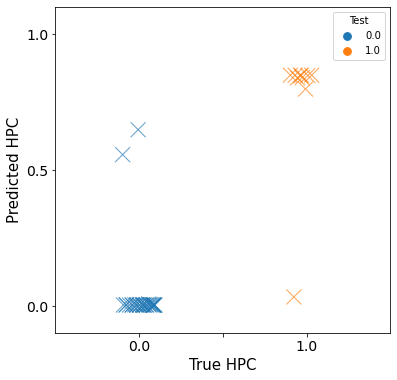

This is the final result by HPC pass/fail prediction by culture-independent FCM-ICC data


In [179]:
# Final results
# You can change styles (dot shape, size, and colors)
plt.figure(figsize=(6,6))
#colors = ["dodgerblue", "red"]
#sb.set_palette(sb.color_palette(colors))
sb.stripplot(x="Test", y="Predict", hue="Test", data=df3, linewidth=1, size=15, marker="x", edgecolors="Set1", alpha=0.7)
plt.ylim(-0.1, 1.1)
#plt.xlim(-0.1, 1.1)

plt.xticks([0.0,0.5,1.0], fontsize=14)
plt.yticks([0.0,0.5,1.0], fontsize=14)
plt.xlabel('True HPC', fontsize=15)
plt.ylabel('Predicted HPC', fontsize=15)
#plt.legend(fontsize=12) 
plt.show()
print("This is the final result by HPC pass/fail prediction by culture-independent FCM-ICC data")

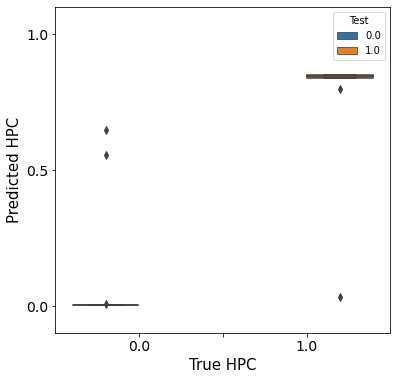

This is the final result by HPC pass/fail prediction by culture-independent FCM-ICC data


In [180]:
plt.figure(figsize=(6,6))
#colors = ["dodgerblue", "red"]
#sb.set_palette(sb.color_palette(colors))
sb.boxplot(x="Test", y="Predict", hue="Test", data=df3)
plt.ylim(-0.1, 1.1)
#plt.xlim(-0.1, 1.1)

plt.xticks([0.0,0.5,1.0], fontsize=14)
plt.yticks([0.0,0.5,1.0], fontsize=14)
plt.xlabel('True HPC', fontsize=15)
plt.ylabel('Predicted HPC', fontsize=15)
#plt.legend(fontsize=12) 
plt.show()
print("This is the final result by HPC pass/fail prediction by culture-independent FCM-ICC data")